In [ ]:
!nvcc --version
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

**GPU**

In [20]:
%%cu
#include <stdio.h>
#define DIM 4096
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    __device__ float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20


__global__ void kernel( Sphere *s, unsigned char *ptr ) {
    // map from threadIdx/BlockIdx to pixel position
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float   ox = (x - DIM/2);
    float   oy = (y - DIM/2);

    float   r=0, g=0, b=0;
    float   maxz = -INF;
    for(int i=0; i<SPHERES; i++) {
        float   n;
        float   t = s[i].hit( ox, oy, &n );
        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    } 

    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
    ptr[offset*4 + 3] = 255;
}

struct DataBlock{
    unsigned char *dev_bitmap;
};

void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RayGpu.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}


int main(void) {
  FILE *fp = fopen("execution_time_GPU_DIM4096.txt", "w");
  // capture the start time 
  // capture the start time 
  cudaEvent_t start, stop;
  cudaEventCreate( &start );
  cudaEventCreate( &stop);
  
  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
  int image_size = DIM* DIM*4;
  unsigned char *dev_bitmap;

  cudaMalloc((void**)&dev_bitmap, image_size); 
  data.dev_bitmap=dev_bitmap;
  Sphere *s;


cudaMalloc((void**)&s, sizeof(Sphere)* SPHERES );


Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );

for (int i=0; i<SPHERES; i++) {
     temp_s[i].r = rnd( 1.0f);
     temp_s[i].g= rnd( 1.0f);
     temp_s[1].b= rnd( 1.0f);
     temp_s[i].x =rnd( 1000.0f)- 500;
     temp_s[i].y =rnd( 1000.0f) - 500;
     temp_s[1].z = rnd( 1000.0f) - 500;
     temp_s[i].radius = rnd( 100.0f) + 20;
     cudaMemcpy( s, temp_s, sizeof(Sphere)* SPHERES, cudaMemcpyHostToDevice);
     free( temp_s);
}

dim3 block(16, 16);
dim3 grid((DIM + block.x - 1) / block.x, (DIM + block.y - 1) / block.y);

cudaEventRecord( start, 0);

kernel<<<grid, block>>>(s, dev_bitmap);

cudaEventRecord( stop, 0);
cudaEventSynchronize(stop);
float elapsedTime;
cudaEventElapsedTime(&elapsedTime, start, stop);
printf("Time: %f ms\n", elapsedTime);

cudaMemcpy( bitmap, dev_bitmap, image_size, cudaMemcpyDeviceToHost);
save_to_file(bitmap);
fprintf(fp, "%f\n", elapsedTime);
    fclose(fp);
}



Time: 0.000000 ms



In [ ]:
# !pip install pillow
# def save_to_file(ptr):
#     img = Image.fromarray(ptr, 'RGB')
#     img.save('RayGpu.jpg')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from PIL import Image

# im = Image.open("/content/RayGpu.ppm")
# im.save("RayGpu.jpg")

In [ ]:
from google.colab import files
import cv2 as cv 

with open('RayGpu.ppm', "r") as file1:
    FileContent = file1.read()
    print(FileContent)

i = cv.imread('RayGpu.ppm')
cv.imwrite('RayGpu.jpg',i)

In [ ]:
from google.colab import files
uploaded = files.upload()

from PIL import Image
im = Image.open("your_ppm_file.ppm")
im.save("your_ppm_file.jpg", "JPEG")

**CPU**

In [21]:
%%cu
#include <stdio.h>
#include <stdlib.h>
#define DIM 4096
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20

void kernel( Sphere *s, unsigned char *ptr ) {
    for(int x=0;x<DIM;x++){
      for(int y=0;y<DIM;y++){
        int offset=x+y*DIM;
        float   ox = (x - DIM/2);
        float   oy = (y - DIM/2);

        float   r=0, g=0, b=0;
        float   maxz = -INF;
        for(int i=0; i<SPHERES; i++) {
            float   n;
            float   t = s[i].hit( ox, oy, &n );
            if (t > maxz) {
                float fscale = n;
                r = s[i].r * fscale;
                g = s[i].g * fscale;
                b = s[i].b * fscale;
                maxz = t;
            }
        } 

        ptr[offset*4 + 0] = (int)(r * 255);
        ptr[offset*4 + 1] = (int)(g * 255);
        ptr[offset*4 + 2] = (int)(b * 255);
        ptr[offset*4 + 3] = 255;
      }
    }
}

void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RayCpu.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}

int main(void) {
    FILE *fp = fopen("execution_time_CPU_DIM4096.txt", "w");
    // capture the start time 
    clock_t start = clock();

    unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
    Sphere *s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );

    srand(time(NULL));
    for (int i=0; i<SPHERES; i++) {
     s[i].r = rnd( 1.0f);
     s[i].g= rnd( 1.0f);
     s[i].b= rnd( 1.0f);
     s[i].x =rnd( 1000.0f)- 500;
     s[i].y =rnd( 1000.0f)- 500;
     s[i].z =rnd( 1000.0f)- 500;
     s[i].radius = rnd( 200.0f) + 20;
    }

    kernel(s, bitmap);
    save_to_file(bitmap);
    clock_t end = clock();
    double elapsed = (double)(end - start) / CLOCKS_PER_SEC;
    printf("elapsed time: %f sec\n", elapsed);
    fprintf(fp, "%f\n", elapsed);
    fclose(fp);
}
   


elapsed time: 7.059020 sec



**PLOT**

In [ ]:
!apt-get install gnuplot
!pip install matplotlib

DIM 2048

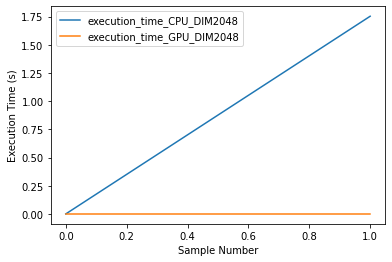

In [19]:
import matplotlib.pyplot as plt

# Read data from files
execution_time1 = [0, ]
with open("execution_time_CPU_DIM2048.txt", "r") as file:
    for line in file:
        execution_time1.append(float(line.strip()))

execution_time2 = [0, ]
with open("execution_time_GPU_DIM2048.txt", "r") as file:
    for line in file:
        execution_time2.append(float(line.strip()))

# Create a line plot
plt.plot(execution_time1, label="execution_time_CPU_DIM2048")
plt.plot(execution_time2, label="execution_time_GPU_DIM2048")
plt.xlabel("Sample Number")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.show()



DIM 4096

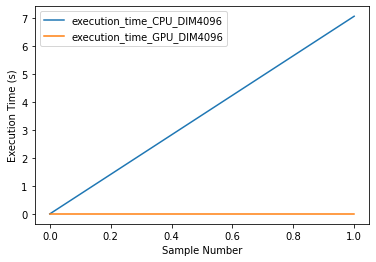

In [22]:
import matplotlib.pyplot as plt

# Read data from files
execution_time1 = [0, ]
with open("execution_time_CPU_DIM4096.txt", "r") as file:
    for line in file:
        execution_time1.append(float(line.strip()))

execution_time2 = [0, ]
with open("execution_time_GPU_DIM4096.txt", "r") as file:
    for line in file:
        execution_time2.append(float(line.strip()))

# Create a line plot
plt.plot(execution_time1, label="execution_time_CPU_DIM4096")
plt.plot(execution_time2, label="execution_time_GPU_DIM4096")
plt.xlabel("Sample Number")
plt.ylabel("Execution Time (s)")
plt.legend()
plt.show()

